# Introduction to machine learning

*Maxime Sangnier*

Fall, 2022

## Practical session 3: nonparametric and ensemble methods

# Table of contents
1. [Nonparametric methods](#part1)
    - [k-nearest neighbors](#part1sec1)
    - [Decision trees](#part1sec2)
1. [Ensemble methods](#part2)
    - [Bagging](#part2sec1)
1. [Random forests](#part3)
1. [Model selection](#part4)


In [1]:
from mllab import *


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Nonparametric methods <a id="part1"></a>
## k-nearest neighbors <a id="part1sec1"></a>


>Given a training dataset $\{(X_1, Y_1), \dots, (X_n, Y_n)\}$, the k-nearest neighbors rule consists in predicting, for $x \in \mathbb R^d$, the majority vote (for classification, or the mean for regression) of the k-nearest neighbors of $x$.
Formally, the predicted class is:
$$
    g(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k \mathbb 1_{Y_{(i)}=y},
$$
where the ranked labeled $\{Y_{(1)}, \dots, Y_{(n)}\}$ are such that $\|X_{(1)}-x\| \le \dots \le \|X_{(n)}-x\|$.

>Given the following dataset, train a [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and display the data along with the classification regions.

>What is the default metric?

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_classes=4,
                           n_features=2, n_redundant=0, n_clusters_per_class=1)

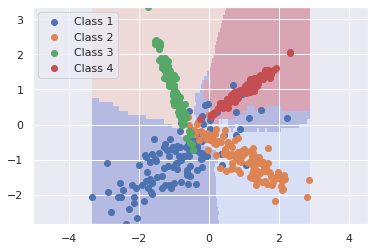

In [3]:
# Answer
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf.fit(X, y)

plotXY(X, y)
map_regions(clf, X)

>Repeat this experiment while making the number of neareset neighbors vary.
Display the results on several subplots with the classification score indicated in the title.

>What appens in the extreme situations where the number of nearest neighbors is either $1$ or $n$ (the size of the training set)?

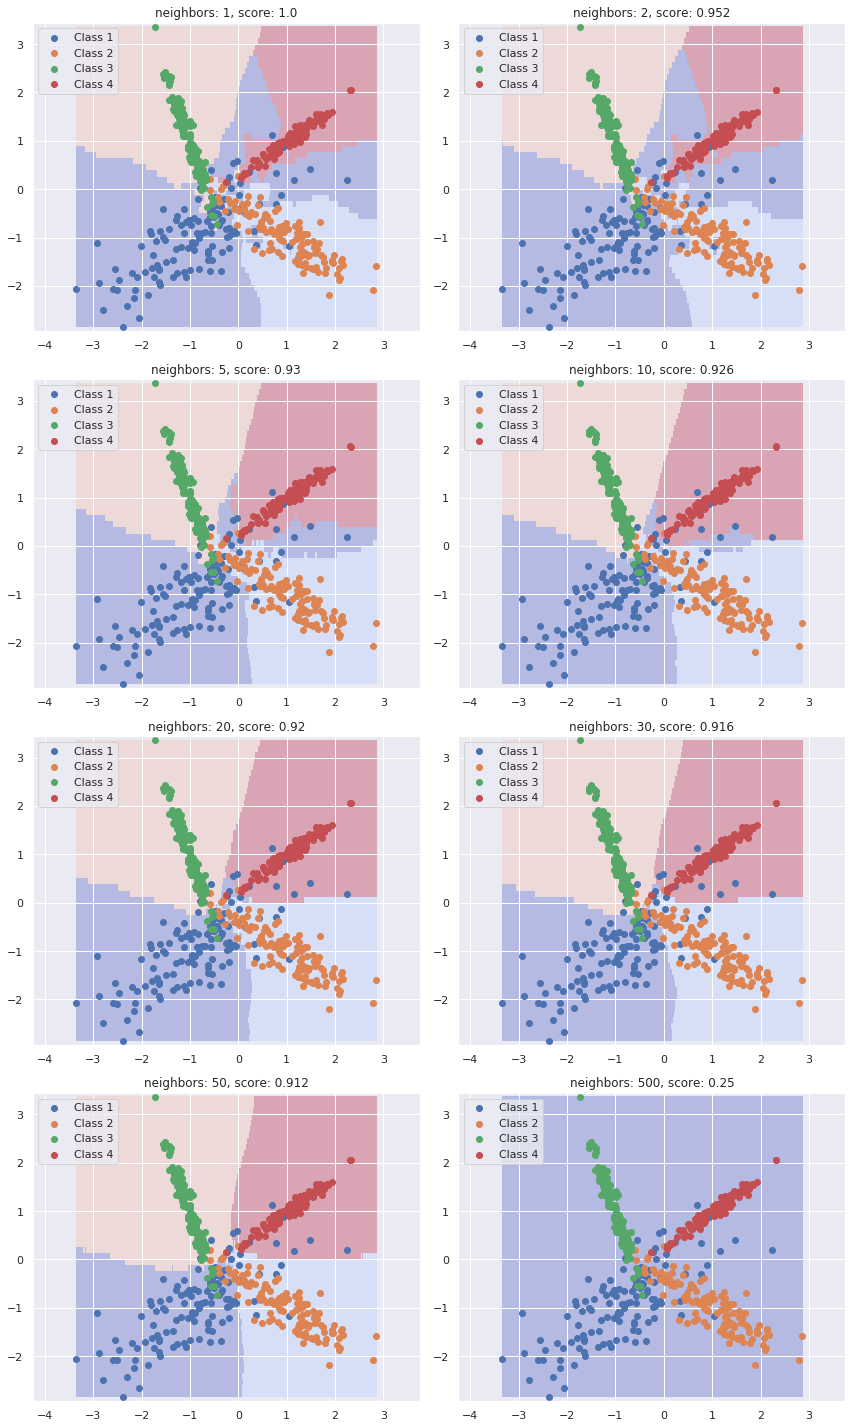

In [4]:
# Answer
plt.figure(figsize=(12, 20))
for it, k in enumerate([1, 2, 5, 10, 20, 30, 50, X.shape[0]]):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    
    plt.subplot(4, 2, it+1)
    plotXY(X, y)
    map_regions(clf, X)
    plt.title("neighbors: {}, score: {}".format(k, clf.score(X, y)))
plt.tight_layout()

>For a point $x \in \mathbb R^d$, the predicted class is given by the majority vote
$$
    g(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k \mathbb 1_{Y_{(i)}=y},
$$
where the ranked labeled $\{Y_{(1)}, \dots, Y_{(n)}\}$ are such that $\|X_{(1)}-x\| \le \dots \le \|X_{(n)}-x\|$.

>We would like, for a while, to weight the vote of each neighbor in the prediction by $e^{-\gamma \|X_{(j)}-x\|^2}$, such that the new classification rule is
$$
    g_\gamma(x) \in \operatorname{arg\,max}_{y \in \mathcal Y} \sum_{i=1}^k e^{-\gamma \|X_{(i)}-x\|^2} \mathbb 1_{Y_{(i)}=y}.
$$

>Again with subplots and score prints, assess the impact of the parameter $\gamma$.
For this purpose, you may want to define the `weights` parameter of the [k-nearest neighbors classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to $x \mapsto e^{-\gamma x^2}$, using a lambda function.

>Relevant values for $\gamma$ are $\{10^{-3}, \dots, 10^4\}$ and `n_neighbors` can be set to $10$.

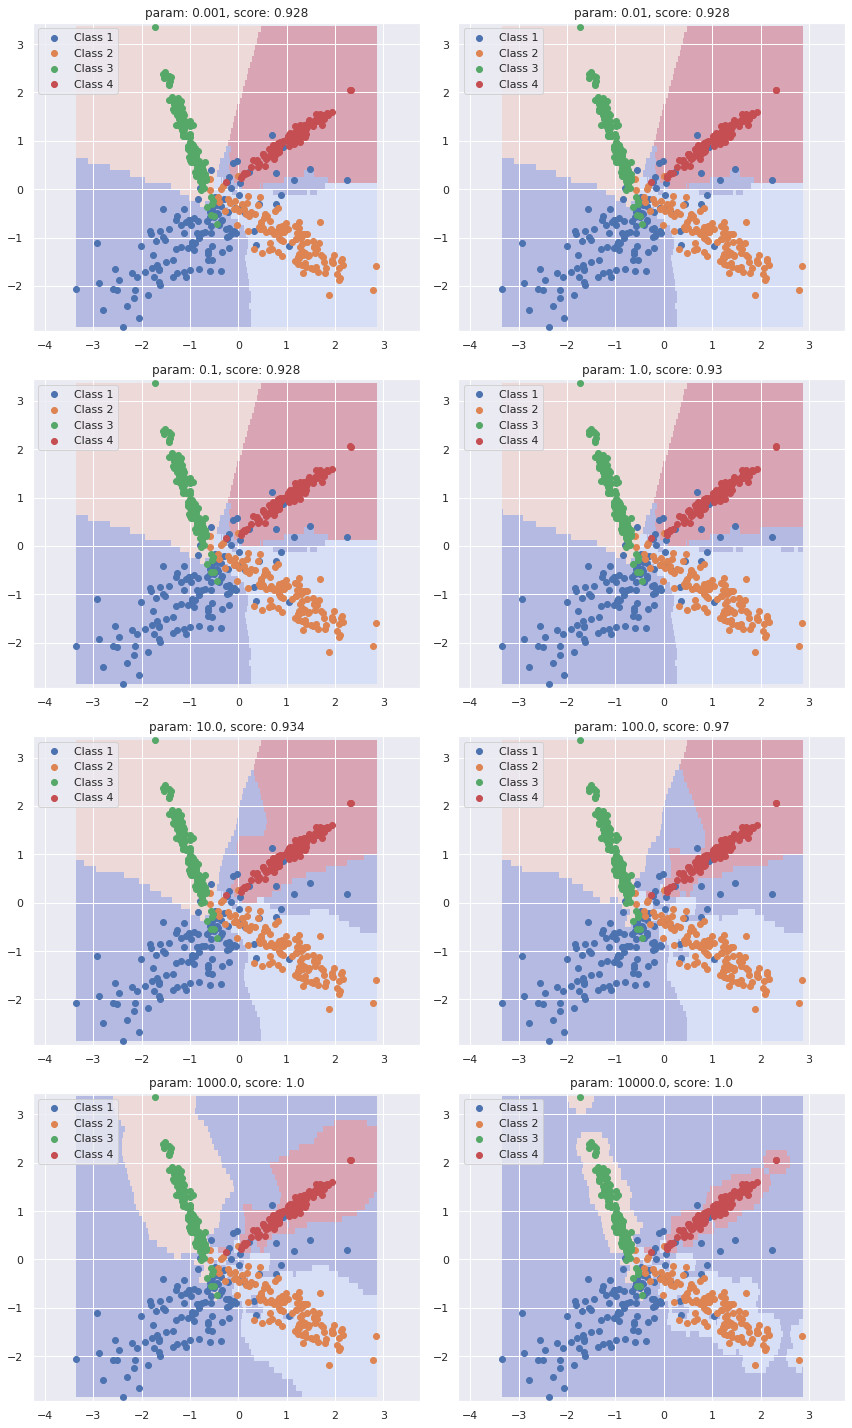

In [5]:
# Answer
n_neighbors = 10

plt.figure(figsize=(12, 20))
for it, param in enumerate(np.logspace(-3, 4, num=8)):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=lambda d: np.exp(-param*d**2))
    clf.fit(X, y)
    
    plt.subplot(4, 2, it+1)
    plotXY(X, y)
    map_regions(clf, X)
    plt.title("param: {}, score: {}".format(param, clf.score(X, y)))
plt.tight_layout()

>Using the [train\_test\_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function, split the dataset into a training and a test set with ratio $0.2-0.8$.
Plot the test accuracy with respect to the number of neighbors.

Text(0.5, 1.0, 'Test accuracy')

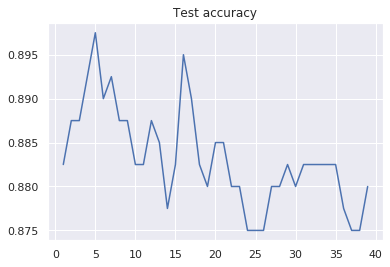

In [6]:
# Answer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

k_values = np.arange(1, 40)
score = []
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
    
plt.plot(k_values, score)
plt.title("Test accuracy")

>Repeat the random split 20 times and plot the mean and the variance of the test accuracy.
What can you say about the variance of this estimator?

Text(0.5, 1.0, 'Test accuracy variance')

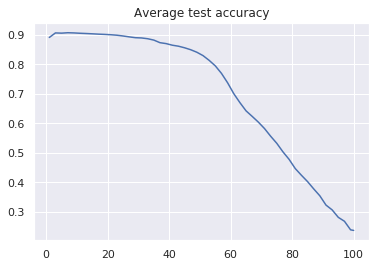

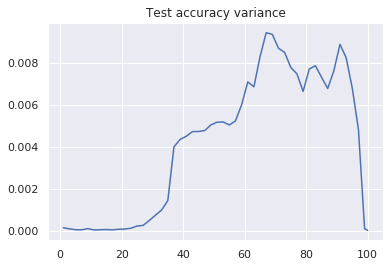

In [36]:
# Answer
from sklearn.model_selection import train_test_split

score = []
for it in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

    k_values = np.r_[np.arange(1, X_train.shape[0], 2), X_train.shape[0]]
    score.append([])
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        score[-1].append(clf.score(X_test, y_test))

plt.plot(k_values, np.mean(score, axis=0))
plt.title("Average test accuracy")

plt.figure()
plt.plot(k_values, np.var(score, axis=0))
plt.title("Test accuracy variance")

>Let us consider the last random split.
Using the [crossval\_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function, find (and print) a good value for the number of nearest neighbors.

>For this parameter, compare the crossvalidation score and the test accuracy.

In [8]:
# Answer
from sklearn.model_selection import cross_val_score

score = []
k_values = np.arange(1, 40, 1)
for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    score.append(cross_val_score(clf, X_train, y_train).mean())
    
ik = np.argmax(score)
n_neighbors = k_values[ik]
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train, y_train)

print("Neighbors:", n_neighbors)
print("Crossval score:", score[ik])
print("Test accuracy:", clf.score(X_test, y_test))

Neighbors: 22
Crossval score: 0.7714460784313726
Test accuracy: 0.775


>Plot the confusion matrix for the best classifier obtained.

In [9]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y, classes=None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    cm = confusion_matrix(y, y_pred)
    
    if classes is None:
        classes = np.unique(y)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Unnormalized confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid()

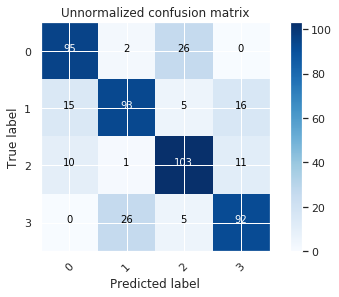

In [10]:
# Answer
y_pred = clf.predict(X)
plot_confusion_matrix(y_pred, y)

## Decision trees <a id="part1sec2"></a>


>Decision trees, and in particular classification and regression trees (CART), are supervised estimators introduced by Leo Breiman et al.
The paradigm of a binary decision tree is to recursively split the space $\mathcal X$ with simple rules such that: is the explicative variable $x_j$ greater than the threshold $\tau$ or not?
Doing so, a decision tree is built, for which each node corresponds to a simple rule (and secondarly to a partition cell of $\mathcal X$).
The final result is a partition of $\mathcal X$ by hypercubes.

>At each step of the learning algorithm, 
>1. consider the partition $\mathcal P = \{\mathcal X\}$;
>1. for each cell $\mathcal A$ of $\mathcal P$, define the two-cell partition
$\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$, where $j \in [d]$ is a feature index and $\tau \in \mathbb R$ is a threhold, and
$$
    \begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
    \end{cases}
$$
are the "left" and "right" parts of $\mathcal A$.
Then, find the best pair (feature, threhold) for splitting:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
where $D$ is a distortion measure for a cell (see below);
>1. replace $\mathcal A$ by $\mathcal L_{j, \tau}$ and $\mathcal R_{j, \tau}$ in the partition $\mathcal P$;
>1. go to 2.

>Given a cell $\mathcal A$, one may define the ratio of observations of $\mathcal A$ of class $y \in \mathcal Y$:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

>Then, the distortion of the cell $\mathcal A$ may be:
>- Gini impurity: $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ (classification);
>- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ (classification);
>- mean squared error: $D(\mathcal A) = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} \left( Y_i - \bar Y_{\mathcal A} \right)^2$, with $\bar Y_{\mathcal A} = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} Y_i$ (regression).

>For regression, Jerome Friedman suggested an improved criterion (in its original paper tackling gradient boosting), referred to as Friedman's mean squared error:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{ \left| \mathcal L_{j, \tau} \right| \left| \mathcal R_{j, \tau} \right| }{ \left| \mathcal L_{j, \tau} \right| + \left| \mathcal R_{j, \tau} \right| }
    \left( \bar Y_{\mathcal L_{j, \tau}} - \bar Y_{\mathcal R_{j, \tau}} \right)^2.
$$

>Last be not least, several stopping rules are of interests:
>- maximal depth of the tree;
>- minimal number of observations required to split an internal node;
>- minimal number of observations required to be at a leaf node;
>- maximal number of leaf nodes.

>We would like to assess the accuracy of a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with respect to the kind of splitting criterion (Gini impurity or entropy) and to the maximal depth allowed.

>For this purpose, fit a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) on the previous dataset and plot 4 curves depicting the classification error for:
>1. the train set and the Gini impurity;
>1. the test set and the Gini impurity;
>1. the train set and the entropy;
>1. the test set and the entropy.

>What can you conclude based on this numerical experiment?

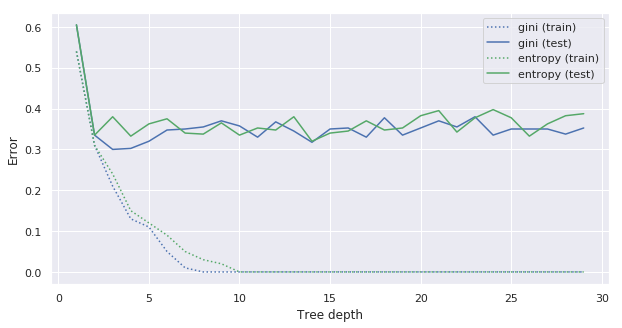

In [11]:
# Answer
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1, 30)
criteria = ["gini", "entropy"]

train_err = []
test_err = []
for criterion in criteria:
    train_err.append([])  # New criteria => new list
    test_err.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        clf.fit(X_train, y_train)
        train_err[-1].append(1-clf.score(X_train, y_train))
        test_err[-1].append(1-clf.score(X_test, y_test))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.plot(depths, train_err[ic], color=colors[ic], linestyle=':',
             label=criterion+" (train)")
    plt.plot(depths, test_err[ic], color=colors[ic], linestyle='-',
             label=criterion+" (test)")
plt.xlabel("Tree depth")
plt.ylabel("Error")
plt.legend(loc="best")

>Map the regions of the "best" (with respect to the test error) decision tree obtained with the Gini impurity.

Best depth for gini criterion: 3.
Test error: 0.30000000000000004


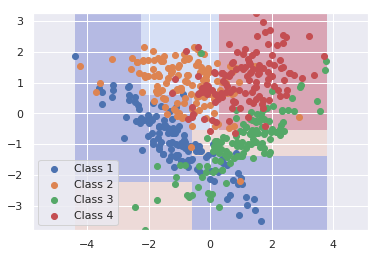

In [12]:
# Answer
criterion = "gini"
ic = np.where([c == criterion for c in criteria])[0][0]  # Index for gini impurity
idepth = np.argmin(test_err[ic])  # Index for best depth
depth = depths[idepth]  # Best depth
print("Best depth for {} criterion: {}.".format(criterion, depth))

# Fit the classifier with the best depth
clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
clf.fit(X_train, y_train)
print("Test error:", 1-clf.score(X_test, y_test))

plotXY(X, y)
map_regions(clf, X)

# Ensemble methods <a id="part2"></a>
## Bagging <a id="part2sec1"></a>


>Bagging is a portmanteau word for *bootstrap aggregating*.
The paradigm of bagging is to train independently several base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, and to build a new classifier by averaging the predictions of the base classifiers:
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
Doing so, the variance of the prediction is reduced and so it is for the global error.
The requirements for such a result are:
>- base classifiers should be more accurate than chance;
>- base classifiers should be estimated independently from each other.

>In practice, base classifiers are trained *quasi-independently* by bootstrapping the training set.

>Bagging is also valid for multiclass problems: for $C$ classes, the prediction is:
$$
    g_n^T(x)
    = \operatorname{arg\,max}_{1 \le j \le C} \frac{1}{T} \sum_{t=1}^T g_t(x) \mathbb 1_{g_t(x)=j}
    = \operatorname{arg\,max}_{1 \le j \le C} \operatorname{card} \left( \left\{ t \in [T] : g_t(x) \mathbb 1_{g_t(x)=j} \right\} \right),
$$
where $g_t \colon \mathbb R^d \to [C]$, which corresponds to the majority vote since base classifiers are equally weighted.

>Finally, one may also bag regressors $g_t \colon \mathbb R^d \to \mathbb R$ by a simple averaging:
$$
    g_n^T(x) = \frac{1}{T} \sum_{t=1}^T g_t(x).
$$

>Assume that we are provided with a sequence of independent classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, such that classifiers are equally good: there exists $p>0.5$ such that $\mathbb P(g_t(X)=Y) = p$ for all $t \in [T]$.
We now consider the bagged classifier
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
What is the distribution of the random variable $\sum_{t=1}^T \mathbb 1_{g_t(X)=Y}$?
Plot its probability mass function for $T=9$ and $p=0.7$.

**Answer**

By independence of the classifiers, the random variable of interest is distributed accordingly to a binomial distribution with parameters T and p.

<StemContainer object of 3 artists>

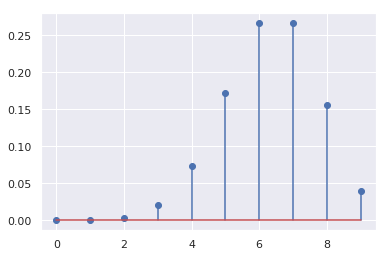

In [13]:
# Answer
from scipy.stats import binom

T, p = 9, 0.7
rv = binom(T, p)
pmf = rv.pmf(np.arange(T+1))

plt.stem(pmf)

>For these particular values of $T$ and $p$, compute numerically $\mathbb P(g_n^T(X)=Y)$.

**Answer**

We have that $g_n^T(X)=Y$ if and only if the majority of base classifiers say that
$g_t(X)=Y$, that is if at least 5 of them say that.

In [14]:
# Answer
print("Probability of success of the bagged classifier:", pmf[T//2+1:].sum())

Probability of success of the bagged classifier: 0.9011913399999991


>Plot the probability of success (or accuracy) with respect to the number of base classifiers $T \in \{1, 2, 3, \dots, 49\}$ (the formula used previously is only valid for odd numbers) for $p \in [0.55, 0.65, \dots, 0.95]$.

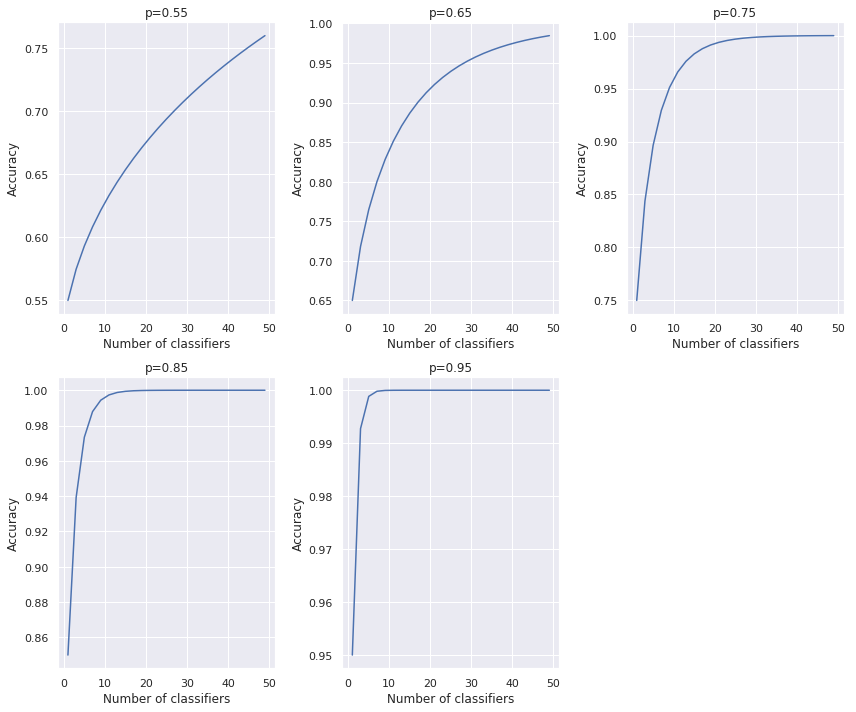

In [15]:
# Answer
Ts = np.arange(1, 50, step=2)

plt.figure(figsize=(12, 10))
for it, p in enumerate(np.arange(0.55, 1, step=0.1)):
    success = [binom.pmf(np.arange(T+1), T, p)[T//2+1:].sum() for T in Ts]
    plt.subplot(2, 3, it+1)
    plt.plot(Ts, success)
    plt.xlabel("Number of classifiers")
    plt.ylabel("Accuracy")
    plt.title("p={}".format(p))
plt.tight_layout()

Complete the following script to implement bagging with regression trees.

In [17]:
# Answer
from sklearn.tree import DecisionTreeRegressor
class BaggingTree(object):
    def __init__(self, n_estimators=10, max_depth=1, max_samples=1.0):
        """
        Parameters:
        - n_estimators: number of estimators
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total numer of points).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_samples = max_samples
        
    def fit(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        n = X.shape[0]  # Sample size
        m = int(self.max_samples * n)  # Number of points for random sampling
        
        self.estimators_ = []
        # Build estimators
        # Todo
        for t in range(self.n_estimators):
            if self.max_samples==1:
                idx = np.random.randint(0, n, n)  # Bootstrap
            else:
                idx = np.random.permutation(n)[:m]  # Random sampling
            self.estimators_.append(DecisionTreeRegressor(max_depth=self.max_depth))
            self.estimators_[-1].fit(X[idx], y[idx])
        # End todo
        return self
    
    def predict(self, X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        # Compute predictions
        # Todo
        y = [reg.predict(X) for reg in self.estimators_]
        predictions = np.asarray(y).mean(axis=0)
        # End todo
        return predictions
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        return np.sum((y - self.predict(X))**2)

>Apply bagging to the following regression dataset and plot (on the same figure), the training data and the prediction for test data.

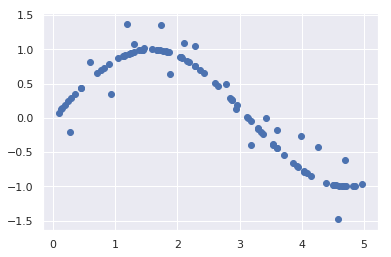

In [18]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)

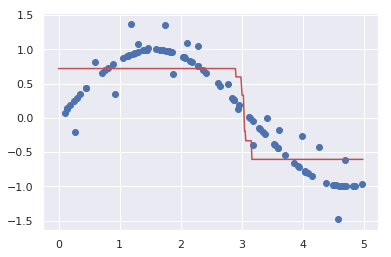

In [19]:
# Answer
reg = BaggingTree()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

plt.scatter(X_train, y_train)
plt.plot(X_test, y_pred, 'r')

>Analyze the behavior of the prediction curve and of the test error with respect to the maximal depth of decision trees and to the number of base regressors.

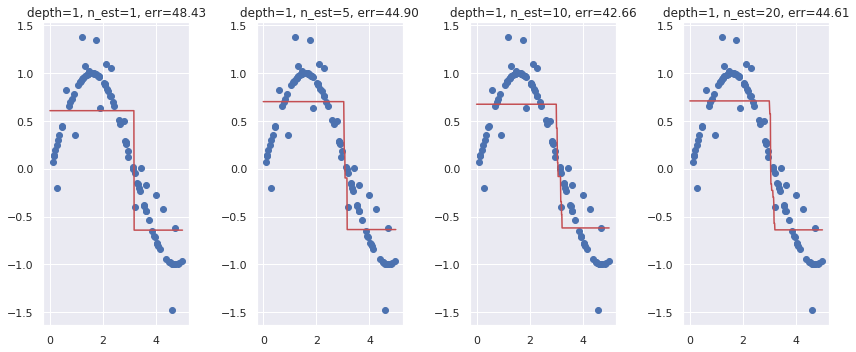

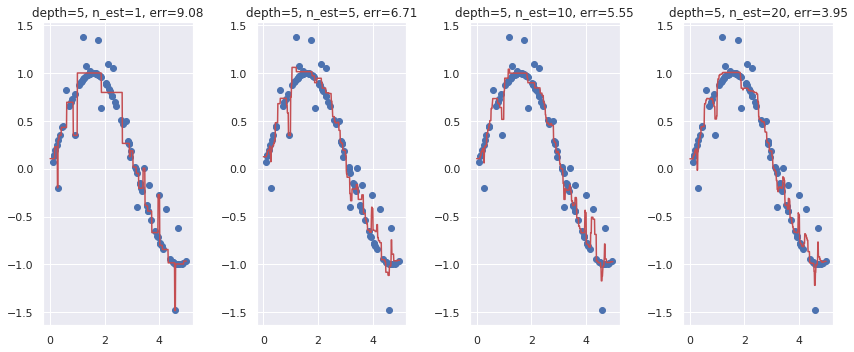

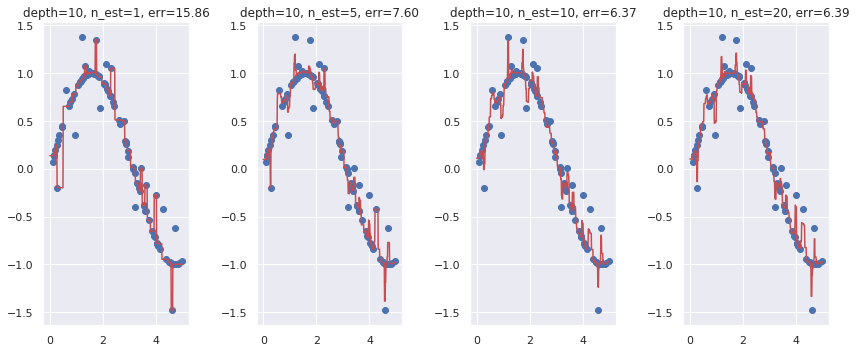

In [20]:
# Answer
for depth in [1, 5, 10]:
    plt.figure(figsize=(12, 5))
    for it, T in enumerate([1, 5, 10, 20]):
        reg = BaggingTree(n_estimators=T, max_depth=depth)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        plt.subplot(1, 4, it+1)
        plt.scatter(X_train, y_train)
        plt.plot(X_test, y_pred, 'r')
        plt.title("depth={0}, n_est={1}, err={2:0.2f}".format(depth, T,
                                                              reg.error(X_test, y_test)))
    plt.tight_layout()

>We consider decision trees with `max_depth = 5`.
Plot two curves (one with bootstrap and one with 25%-subsampling) showing the test error with respect to the number of base regressors.
What can we conclude?

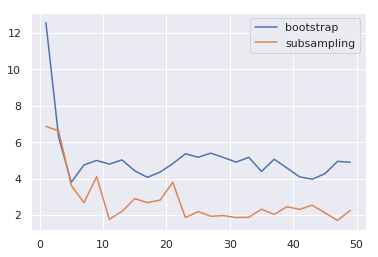

In [21]:
# Answer
depth = 5

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingTree(max_depth=depth, max_samples=1)),
                  ("subsampling", BaggingTree(max_depth=depth, max_samples=0.25))]:
    error = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        error.append(reg.error(X_test, y_test))
    plt.plot(estim, error, label=name)
plt.legend(loc="best")

# Random forests <a id="part3"></a>


>Random forests are bagged trees: for binary classification, a random forest is
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right),
$$
where the base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, are learned quasi-independently by bootstrap.

>However, in order to enforce the independent learning, each decision tree $g_t$ owns an additional randomization step in its learning procedure:
1. at each cell, select a subset of features at random;
1. find the best pair (feature, threshold) for splitting.

>The following script loads and preprocesses the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).
Explain each step and indicate its purpose.

>Is it useful for decision trees?

In [22]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

>On the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), compare scikit-learn [bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (with bootstrap and 25%-subsampling) and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).
For this purpose, consider `max_depth = 5` and plot three curves showing the regression score for the test set with respect to the number of base regressors.
What can we conclude?

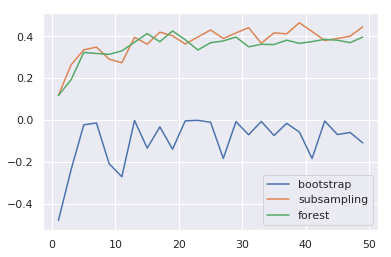

In [23]:
# Answer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

depth = 5
params = {"max_depth": depth}

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                 max_samples=1, bootstrap=True)),
                  ("subsampling", BaggingRegressor(base_estimator=DecisionTreeRegressor(**params),
                                                   max_samples=0.25, bootstrap=False)),
                  ("forest", RandomForestRegressor(**params))]:
    score = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)
plt.legend(loc="best")

# Model selection <a id="part4"></a>


>Load the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits), split it randomly and preprocess it similarly to the diabetes dataset (be careful, we are now handling a classification dataset).

In [24]:
# Answer
from sklearn.datasets import load_digits

data = load_digits()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

>We aim at comparing three models based on the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits):
1. [gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html);
1. [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html);
1. [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

>For each model, some possible values of parameters are defined below.
Explain the role of these parameters.

In [25]:
# Grid parameters
tree_params = {"max_depth": [5, 10, 15],
              "n_estimators": [10, 100]}  # Parameters for random forests
gb_params = tree_params.copy()  # Parameters for gradient boosting
gb_params.update({"learning_rate": np.logspace(-2, 0, num=3),
                 "max_features": [0.1]})
lr_params = {"C": np.logspace(-3, 3, num=7)}  # Parameters for logistic regression

>With the training set previously generated, perform a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in order to determine "good" parameters among the ones proposed above.
Compare the test scores of the models trained with the "best" parameters.

In [26]:
# Auxiliary parameters
gs_params = {"cv": 3, "n_jobs": -1, "verbose": 1}

In [27]:
# Answer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

scores = []
for name, clf, params in [("Gradient boosting", GradientBoostingClassifier(), gb_params),
                          ("Random forest", RandomForestClassifier(), tree_params),
                          ("Logistic regression", LogisticRegression(), lr_params)]:
    grid = GridSearchCV(estimator=clf, param_grid=params, **gs_params)
    grid.fit(X_train, y_train)
    scores.append((name, grid.score(X_test, y_test), grid.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   27.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.4s finished


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.0s finished


In [28]:
# Answer
for name, score, params in scores:
    print("Score {0}: {1:0.2f}\t".format(name, score), params)

Score Gradient boosting: 0.98	 {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Score Random forest: 0.98	 {'max_depth': 10, 'n_estimators': 100}
Score Logistic regression: 0.97	 {'C': 0.1}


>The general pattern of this numerical experiment is:
1. spliting randomly the dataset;
1. preprocessing it;
1. finding suitable parameters by grid search;
1. assessing the generalization error.

>Repeat this experiment 20 times and record the score for each method and each run.
Print the mean score and the standard deviation for each method.

In [ ]:
# Answer
gs_params = {"cv": 3, "n_jobs": -1, "verbose": 0}

scores = []
for run in range(20):
    # Print
    print("Run", run)
    
    # Dataset
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Score saving
    scores.append([])
    
    # Grid search
    for name, clf, params in [("Gradient boosting", GradientBoostingClassifier(), gb_params),
                          ("Random forest", RandomForestClassifier(), tree_params),
                          ("Logistic regression", LogisticRegression(), lr_params)]:
        grid = GridSearchCV(estimator=clf, param_grid=params, **gs_params)
        grid.fit(X_train, y_train)
        scores[-1].append(grid.score(X_test, y_test))

In [ ]:
# Answer
scores = np.asarray(scores)
print("\t{}\t{}\t{}".format("Gradient boosting", "Random forest", "Logistic regression"))
print("Mean\t{}\t{}\t{}".format(*scores.mean(axis=0)))
print("Std\t{}\t{}\t{}".format(*scores.std(axis=0)))

>Perform a [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html) to assess the difference between the mean scores of Gradient boosting and random forests.

In [ ]:
# Answer
from scipy.stats import wilcoxon

print("Grandient boosting vs random forest:", wilcoxon(scores[:, 0], scores[:, 1]))